# Planogram Compliance with Roboflow CLIP API

This notebook uses Roboflow's workflow API to:
1. Detect and crop products from shelf images
2. Generate CLIP embeddings for each crop
3. Match crops against card thumbnail database using cosine similarity

In [ ]:
# Install required dependencies
!pip install inference-sdk pillow numpy matplotlib torch transformers

  Using cached markupsafe-3.0.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 47.5 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 26.6 MB/s  0:00:00
Using cached markupsafe-3.0.3-cp311-cp311-macosx_11_0_arm64.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [torch]32m7/8 [torch]]x]


In [40]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from inference_sdk import InferenceHTTPClient

# Configuration
API_KEY = "W7ZLH2wzvGvK9yzBOpAv"
WORKSPACE = "sonic-eyes-ventures"
WORKFLOW_ID = "custom-workflow-3-2"
MIN_CROP_SIZE = 10  # Minimum width/height in pixels

# Paths
TEST_IMAGE = "test.png"
CARD_THUMBNAILS_DIR = "card_thumbnails (1)"

# Initialize Roboflow client
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key=API_KEY
)

print("✓ Roboflow client initialized")

✓ Roboflow client initialized


## Step 1: Process Shelf Image (test.png)
Run the shelf image through Roboflow workflow to detect products (SAM), then generate local CLIP embeddings for each crop

In [44]:
# Install PyTorch and Transformers for local CLIP model
!pip install torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 15.5 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 30.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [transformers] [transformers]ub]


In [45]:
# Install and set up local CLIP model for generating embeddings
import torch
from transformers import CLIPProcessor, CLIPModel

# Check for GPU availability
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-base-patch32"

print(f"Loading CLIP model on device: {DEVICE}")
processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE).eval()

@torch.inference_mode()
def embed_image_local(image) -> np.ndarray:
    """Generate CLIP embedding for a PIL Image"""
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    elif not isinstance(image, Image.Image):
        image = Image.fromarray(image).convert("RGB")
    
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    out = model.get_image_features(**inputs)
    vec = torch.nn.functional.normalize(out.squeeze(0), dim=0)
    return vec.cpu().numpy()

print("✓ Local CLIP model ready")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIP model on device: mps
✓ Local CLIP model ready


## Step 1: Process Shelf Image (test.png)
Run the shelf image through Roboflow workflow to detect products and get CLIP embeddings

## Step 2: Process Card Thumbnails
Generate CLIP embeddings for all card thumbnails using local CLIP model

In [47]:
# Extract crops from SAM predictions and generate local CLIP embeddings
shelf_crops = []

# Load the shelf image
shelf_img = Image.open(TEST_IMAGE).convert("RGB")
print(f"Loaded shelf image: {shelf_img.size}")

# Parse the workflow result for SAM predictions
for output in shelf_result:
    # Get SAM predictions (detections)
    sam_predictions = output.get('sam', {}).get('predictions', [])
    
    print(f"\nFound {len(sam_predictions)} SAM predictions")
    print("Generating local CLIP embeddings for each crop...")
    
    # Process each detection
    for i, detection in enumerate(sam_predictions):
        # Get bounding box from SAM prediction (center format)
        x_center = detection.get('x', 0)
        y_center = detection.get('y', 0)
        width = detection.get('width', 0)
        height = detection.get('height', 0)
        
        # Filter crops that are too small
        if width >= MIN_CROP_SIZE and height >= MIN_CROP_SIZE:
            # Convert from center coords to corner coords for cropping
            x1 = int(x_center - width/2)
            y1 = int(y_center - height/2)
            x2 = int(x_center + width/2)
            y2 = int(y_center + height/2)
            
            # Ensure coordinates are within image bounds
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(shelf_img.width, x2)
            y2 = min(shelf_img.height, y2)
            
            # Crop the region
            crop = shelf_img.crop((x1, y1, x2, y2))
            
            # Generate CLIP embedding locally
            try:
                embedding = embed_image_local(crop)
                
                shelf_crops.append({
                    'bbox': (x_center, y_center, width, height),
                    'embedding': embedding,
                    'confidence': detection.get('confidence', 1.0)
                })
                
                if (i + 1) % 20 == 0:
                    print(f"  Processed {i + 1}/{len(sam_predictions)} crops...")
            
            except Exception as e:
                print(f"  Warning: Failed to embed crop {i}: {e}")
                continue

print(f"\n✓ Generated embeddings for {len(shelf_crops)} crops (>{MIN_CROP_SIZE}px)")
if shelf_crops:
    print(f"  Sample crop bbox: {shelf_crops[0]['bbox']}")
    print(f"  Embedding dimension: {shelf_crops[0]['embedding'].shape}")

Loaded shelf image: (624, 752)

Found 176 SAM predictions
Generating local CLIP embeddings for each crop...
  Processed 20/176 crops...
  Processed 60/176 crops...
  Processed 100/176 crops...
  Processed 120/176 crops...
  Processed 140/176 crops...

✓ Generated embeddings for 103 crops (>10px)
  Sample crop bbox: (177.5, 701.0, 69.0, 90.0)
  Embedding dimension: (512,)


In [48]:
# Generate local CLIP embeddings for all card thumbnails
card_dir = Path(CARD_THUMBNAILS_DIR)
card_paths = sorted(list(card_dir.glob('*.jpg')) + list(card_dir.glob('*.png')))

print(f"Found {len(card_paths)} card thumbnails")
print("Generating local CLIP embeddings...")

card_embeddings = []
card_names = []

for i, card_path in enumerate(card_paths):
    if (i + 1) % 50 == 0:
        print(f"  Processing card {i+1}/{len(card_paths)}...")
    
    try:
        # Generate embedding using local CLIP model
        embedding = embed_image_local(str(card_path))
        card_embeddings.append(embedding)
        card_names.append(card_path.name)
    except Exception as e:
        print(f"  Warning: Failed to process {card_path.name}: {e}")
        continue

# Convert to numpy array for efficient similarity computation
if card_embeddings:
    card_embeddings = np.stack(card_embeddings, axis=0)
    print(f"\n✓ Successfully generated {len(card_names)} embeddings")
    print(f"  Embeddings shape: {card_embeddings.shape}")
else:
    print(f"\n⚠ Warning: No card embeddings were generated.")

Found 370 card thumbnails
Generating local CLIP embeddings...
  Processing card 50/370...
  Processing card 100/370...
  Processing card 150/370...
  Processing card 200/370...
  Processing card 250/370...
  Processing card 300/370...
  Processing card 350/370...

✓ Successfully generated 370 embeddings
  Embeddings shape: (370, 512)


In [49]:
# Get all card thumbnail paths
card_dir = Path(CARD_THUMBNAILS_DIR)
card_paths = sorted(list(card_dir.glob('*.jpg')) + list(card_dir.glob('*.png')))

print(f"Found {len(card_paths)} card thumbnails")

# Process each card through Roboflow to get CLIP embeddings
card_embeddings = []
card_names = []

for i, card_path in enumerate(card_paths):
    if i % 10 == 0:
        print(f"Processing card {i+1}/{len(card_paths)}...")
    
    try:
        # Run workflow on card thumbnail
        card_result = client.run_workflow(
            workspace_name=WORKSPACE,
            workflow_id=WORKFLOW_ID,
            images={"image": str(card_path)},
            use_cache=True
        )
        
        # Extract embedding from result
        # Expected structure: [{"clip_embeddings": [...], "sam": {"predictions": [...]}}]
        embedding = None
        
        for output in card_result:
            clip_embeddings_list = output.get('clip_embeddings', [])
            
            # Use the first embedding if available
            if clip_embeddings_list and len(clip_embeddings_list) > 0:
                embedding = clip_embeddings_list[0]
                break
            
            # Alternatively, if there are SAM predictions, use the first one's embedding
            sam_predictions = output.get('sam', {}).get('predictions', [])
            if sam_predictions and len(sam_predictions) > 0 and len(clip_embeddings_list) > 0:
                embedding = clip_embeddings_list[0]
                break
        
        if embedding is not None and len(embedding) > 0:
            card_embeddings.append(np.array(embedding))
            card_names.append(card_path.name)
    
    except Exception as e:
        print(f"  Warning: Failed to process {card_path.name}: {e}")
        continue

# Convert to numpy array for efficient similarity computation
if card_embeddings:
    card_embeddings = np.stack(card_embeddings, axis=0)
    print(f"\n✓ Successfully processed {len(card_names)} cards")
    print(f"  Embeddings shape: {card_embeddings.shape}")
else:
    print(f"\n⚠ Warning: No card embeddings were generated. Check workflow configuration.")

Found 370 card thumbnails
Processing card 1/370...
Processing card 11/370...
Processing card 21/370...
Processing card 31/370...
Processing card 41/370...
Processing card 51/370...
Processing card 61/370...
Processing card 71/370...
Processing card 81/370...


KeyboardInterrupt: 

In [ ]:
# Get all card thumbnail paths
card_dir = Path(CARD_THUMBNAILS_DIR)
card_paths = sorted(list(card_dir.glob('*.jpg')) + list(card_dir.glob('*.png')))

print(f"Found {len(card_paths)} card thumbnails")

# Process each card through Roboflow to get CLIP embeddings
card_embeddings = []
card_names = []

for i, card_path in enumerate(card_paths):
    if i % 10 == 0:
        print(f"Processing card {i+1}/{len(card_paths)}...")
    
    try:
        # Run workflow on card thumbnail
        card_result = client.run_workflow(
            workspace_name=WORKSPACE,
            workflow_id=WORKFLOW_ID,
            images={"image": str(card_path)},
            use_cache=True
        )
        
        # Extract embedding from result
        # Adjust based on your workflow output structure
        embedding = None
        
        for output in card_result:
            # Try to get the whole image embedding or first detection
            if 'embedding' in output:
                embedding = output['embedding']
                break
            elif 'clip_embedding' in output:
                embedding = output['clip_embedding']
                break
            elif 'predictions' in output and len(output['predictions']) > 0:
                embedding = output['predictions'][0].get('embedding')
                break
        
        if embedding is not None:
            card_embeddings.append(np.array(embedding))
            card_names.append(card_path.name)
    
    except Exception as e:
        print(f"  Warning: Failed to process {card_path.name}: {e}")
        continue

# Convert to numpy array for efficient similarity computation
card_embeddings = np.stack(card_embeddings, axis=0)

print(f"\n✓ Successfully processed {len(card_names)} cards")
print(f"  Embeddings shape: {card_embeddings.shape}")

## Option B: Local CLIP Embeddings (Alternative - Commented Out)
Use local CLIP model to generate embeddings instead of Roboflow API

In [ ]:
# # OPTION B: Generate card embeddings locally with CLIP
# # Uncomment this cell to use local CLIP model instead of Roboflow API
# 
# !pip install "torch>=2.2" "transformers>=4.45" pillow
# 
# import torch
# from transformers import CLIPProcessor, CLIPModel
# 
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# MODEL_ID = "openai/clip-vit-base-patch32"
# 
# processor = CLIPProcessor.from_pretrained(MODEL_ID)
# model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE).eval()
# 
# @torch.inference_mode()
# def embed_image_local(path: str) -> np.ndarray:
#     img = Image.open(path).convert("RGB")
#     inputs = processor(images=img, return_tensors="pt").to(DEVICE)
#     out = model.get_image_features(**inputs)
#     vec = torch.nn.functional.normalize(out.squeeze(0), dim=0)
#     return vec.cpu().numpy()
# 
# # Generate embeddings for all card thumbnails
# card_dir = Path(CARD_THUMBNAILS_DIR)
# card_paths = sorted(list(card_dir.glob('*.jpg')) + list(card_dir.glob('*.png')))
# 
# card_embeddings = []
# card_names = []
# 
# for i, card_path in enumerate(card_paths):
#     if i % 50 == 0:
#         print(f"Processing {i}/{len(card_paths)}...")
#     
#     try:
#         embedding = embed_image_local(str(card_path))
#         card_embeddings.append(embedding)
#         card_names.append(card_path.name)
#     except Exception as e:
#         print(f"Warning: Failed to process {card_path.name}: {e}")
#         continue
# 
# card_embeddings = np.stack(card_embeddings, axis=0)
# print(f"✓ Generated {len(card_names)} embeddings locally")
# print(f"  Shape: {card_embeddings.shape}")

In [50]:
# Check if we have data to work with
if len(shelf_crops) == 0:
    print("⚠ No shelf crops detected. Cannot perform matching.")
    matches = []
elif len(card_embeddings) == 0:
    print("⚠ No card embeddings available. Cannot perform matching.")
    matches = []
else:
    # Normalize embeddings for cosine similarity
    # (If Roboflow already returns normalized vectors, this may not be needed)
    def normalize(embeddings):
        norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
        return embeddings / (norms + 1e-8)

    card_embeddings_norm = normalize(card_embeddings)

    # Match each crop to the best card
    matches = []

    for i, crop in enumerate(shelf_crops):
        # Normalize crop embedding
        crop_embedding = normalize(crop['embedding'].reshape(1, -1))
        
        # Compute cosine similarity with all cards
        similarities = card_embeddings_norm @ crop_embedding.T
        similarities = similarities.squeeze()
        
        # Find best match
        best_idx = int(np.argmax(similarities))
        best_score = float(similarities[best_idx])
        
        # Get top 3 matches
        top3_idx = np.argsort(-similarities)[:3]
        top3_matches = [(card_names[idx], float(similarities[idx])) for idx in top3_idx]
        
        matches.append({
            'crop_id': i,
            'bbox': crop['bbox'],
            'best_match': card_names[best_idx],
            'similarity': best_score,
            'top3': top3_matches
        })
        
        print(f"\nCrop {i} @ {crop['bbox']}:")
        print(f"  Best: {card_names[best_idx]} (score: {best_score:.4f})")
        print(f"  Top 3: {top3_matches}")

    print(f"\n✓ Matched {len(matches)} crops to cards")


Crop 0 @ (177.5, 701.0, 69.0, 90.0):
  Best: 206009.jpg (score: 0.6456)
  Top 3: [('206009.jpg', 0.6456495577034255), ('206004.jpg', 0.630776575984649)]

Crop 1 @ (562.5, 157.0, 67.0, 64.0):
  Best: 206004.jpg (score: 0.6394)
  Top 3: [('206004.jpg', 0.6394263738222488), ('206009.jpg', 0.5852086549100391)]

Crop 2 @ (110.5, 350.5, 63.0, 57.0):
  Best: 206004.jpg (score: 0.6251)
  Top 3: [('206004.jpg', 0.6250873716506805), ('206009.jpg', 0.5714657486603075)]

Crop 3 @ (115.5, 225.5, 67.0, 65.0):
  Best: 206004.jpg (score: 0.6126)
  Top 3: [('206004.jpg', 0.6126142856246782), ('206009.jpg', 0.5828494512128772)]

Crop 4 @ (430.5, 93.0, 61.0, 64.0):
  Best: 206004.jpg (score: 0.6405)
  Top 3: [('206004.jpg', 0.6405454928938805), ('206009.jpg', 0.603797367960845)]

Crop 5 @ (243.5, 550.0, 63.0, 66.0):
  Best: 206004.jpg (score: 0.5758)
  Top 3: [('206004.jpg', 0.5758074812067199), ('206009.jpg', 0.5182951410991102)]

Crop 6 @ (381.0, 411.5, 66.0, 69.0):
  Best: 206004.jpg (score: 0.6073)


In [52]:
# Normalize embeddings for cosine similarity
# (If Roboflow already returns normalized vectors, this may not be needed)
def normalize(embeddings):
    norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
    return embeddings / (norms + 1e-8)

card_embeddings_norm = normalize(card_embeddings)

# Match each crop to the best card
matches = []

for i, crop in enumerate(shelf_crops):
    # Normalize crop embedding
    crop_embedding = normalize(crop['embedding'].reshape(1, -1))
    
    # Compute cosine similarity with all cards
    similarities = card_embeddings_norm @ crop_embedding.T
    similarities = similarities.squeeze()
    
    # Find best match
    best_idx = int(np.argmax(similarities))
    best_score = float(similarities[best_idx])
    
    # Get top 3 matches
    top3_idx = np.argsort(-similarities)[:3]
    top3_matches = [(card_names[idx], float(similarities[idx])) for idx in top3_idx]
    
    matches.append({
        'crop_id': i,
        'bbox': crop['bbox'],
        'best_match': card_names[best_idx],
        'similarity': best_score,
        'top3': top3_matches
    })
    
    print(f"\nCrop {i} @ {crop['bbox']}:")
    print(f"  Best: {card_names[best_idx]} (score: {best_score:.4f})")
    print(f"  Top 3: {top3_matches}")

print(f"\n✓ Matched {len(matches)} crops to cards")


Crop 0 @ (177.5, 701.0, 69.0, 90.0):
  Best: 206009.jpg (score: 0.6456)
  Top 3: [('206009.jpg', 0.6456495577034255), ('206004.jpg', 0.630776575984649)]

Crop 1 @ (562.5, 157.0, 67.0, 64.0):
  Best: 206004.jpg (score: 0.6394)
  Top 3: [('206004.jpg', 0.6394263738222488), ('206009.jpg', 0.5852086549100391)]

Crop 2 @ (110.5, 350.5, 63.0, 57.0):
  Best: 206004.jpg (score: 0.6251)
  Top 3: [('206004.jpg', 0.6250873716506805), ('206009.jpg', 0.5714657486603075)]

Crop 3 @ (115.5, 225.5, 67.0, 65.0):
  Best: 206004.jpg (score: 0.6126)
  Top 3: [('206004.jpg', 0.6126142856246782), ('206009.jpg', 0.5828494512128772)]

Crop 4 @ (430.5, 93.0, 61.0, 64.0):
  Best: 206004.jpg (score: 0.6405)
  Top 3: [('206004.jpg', 0.6405454928938805), ('206009.jpg', 0.603797367960845)]

Crop 5 @ (243.5, 550.0, 63.0, 66.0):
  Best: 206004.jpg (score: 0.5758)
  Top 3: [('206004.jpg', 0.5758074812067199), ('206009.jpg', 0.5182951410991102)]

Crop 6 @ (381.0, 411.5, 66.0, 69.0):
  Best: 206004.jpg (score: 0.6073)


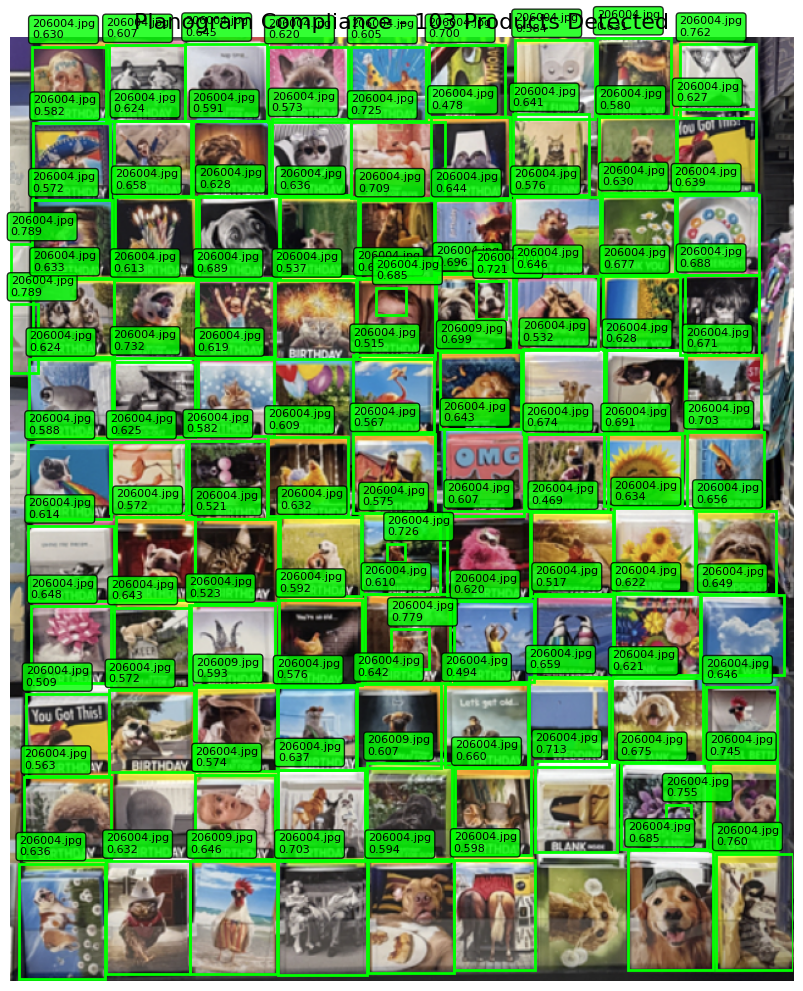


✓ Visualization complete!


In [53]:
# Load and display the shelf image with matches
shelf_img = Image.open(TEST_IMAGE)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.imshow(shelf_img)

if matches:
    # Draw bounding boxes with labels
    for match in matches:
        x, y, w, h = match['bbox']
        
        # Convert from center coords to corner coords if needed
        # (Adjust based on your bbox format)
        x1 = x - w/2
        y1 = y - h/2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2,
            edgecolor='lime',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label with card name and similarity score
        label = f"{match['best_match']}\n{match['similarity']:.3f}"
        ax.text(
            x1, y1 - 5,
            label,
            bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8),
            fontsize=8,
            verticalalignment='bottom'
        )
    
    title = f"Planogram Compliance - {len(matches)} Products Detected"
else:
    # No matches found - just show the image
    title = "Planogram Compliance - No Products Detected"
    ax.text(
        0.5, 0.5, 
        'No products detected\nCheck workflow configuration or image quality',
        transform=ax.transAxes,
        fontsize=14,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7)
    )

ax.axis('off')
plt.title(title, fontsize=16)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")

In [ ]:
# Load and display the shelf image with matches
shelf_img = Image.open(TEST_IMAGE)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.imshow(shelf_img)

# Draw bounding boxes with labels
for match in matches:
    x, y, w, h = match['bbox']
    
    # Convert from center coords to corner coords if needed
    # (Adjust based on your bbox format)
    x1 = x - w/2
    y1 = y - h/2
    
    # Draw rectangle
    rect = patches.Rectangle(
        (x1, y1), w, h,
        linewidth=2,
        edgecolor='lime',
        facecolor='none'
    )
    ax.add_patch(rect)
    
    # Add label with card name and similarity score
    label = f"{match['best_match']}\n{match['similarity']:.3f}"
    ax.text(
        x1, y1 - 5,
        label,
        bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8),
        fontsize=8,
        verticalalignment='bottom'
    )

ax.axis('off')
plt.title(f"Planogram Compliance - {len(matches)} Products Detected", fontsize=16)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")

## Summary Statistics

In [51]:
# Print summary statistics
if matches:
    similarities = [m['similarity'] for m in matches]
    
    print("=" * 50)
    print("SUMMARY")
    print("=" * 50)
    print(f"Total crops detected: {len(shelf_crops)}")
    print(f"Valid crops (>{MIN_CROP_SIZE}px): {len(matches)}")
    print(f"Card database size: {len(card_names)}")
    print(f"\nSimilarity Scores:")
    print(f"  Mean: {np.mean(similarities):.4f}")
    print(f"  Median: {np.median(similarities):.4f}")
    print(f"  Min: {np.min(similarities):.4f}")
    print(f"  Max: {np.max(similarities):.4f}")
    print(f"\nConfidence levels:")
    print(f"  High (>0.9): {sum(s > 0.9 for s in similarities)}")
    print(f"  Medium (0.7-0.9): {sum(0.7 <= s <= 0.9 for s in similarities)}")
    print(f"  Low (<0.7): {sum(s < 0.7 for s in similarities)}")
else:
    print("No matches found. Check workflow output structure.")

SUMMARY
Total crops detected: 103
Valid crops (>10px): 103
Card database size: 2

Similarity Scores:
  Mean: 0.6319
  Median: 0.6303
  Min: 0.4695
  Max: 0.7892

Confidence levels:
  High (>0.9): 0
  Medium (0.7-0.9): 16
  Low (<0.7): 87
